In [13]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import List

In [2]:
torch.__version__

'1.4.0'

In [36]:
# !pip install keras
# !pip install tensorflow

In [3]:
from keras.datasets import imdb

Using TensorFlow backend.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [5]:
def adjustAxes(axis_obj, FONTSIZE, x_rotate=0, y_rotate=0):
    for tick in axis_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(FONTSIZE)
        tick.label.set_rotation(x_rotate)
    for tick in axis_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(FONTSIZE)
        tick.label.set_rotation(y_rotate)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [7]:
X_valid = train_data[:10000]
y_valid = train_labels[:10000]

X_train = train_data[10000:]
y_train = train_labels[10000:]

In [84]:
class IMDBdataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        sample = {'feature': x, 'target': y}
        if self.transform:
            sample = self.transform(sample)
        return sample    

In [85]:
class Vectorize(object):
    
    def __init__(self, dimension=10000):
        self.dimension = dimension
        
    def __call__(self, sample):
        x = sample['feature']
        y = sample['target']
        vec = np.zeros(self.dimension)
        vec[x] = 1.
        return {'feature': vec, 'target': y}    

In [86]:
class ToTensor(object):
    
    def __call__(self, sample):
        x = sample['feature']
        y = sample['target']
        return {'feature': torch.from_numpy(x).float(), 'target': torch.from_numpy(np.array(y)).float()}

In [88]:
tsfms = transforms.Compose([Vectorize(10000), ToTensor()])
imdb_train_dataset = IMDBdataset(X_train, y_train, tsfms)
imdb_valid_dataset = IMDBdataset(X_valid, y_valid, tsfms)

In [89]:
lr_finder_dataloader = DataLoader(imdb_train_dataset, batch_size=300, shuffle=True, num_workers=4)
train_dataloader = DataLoader(imdb_train_dataset, batch_size=512, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(imdb_valid_dataset, batch_size=512, shuffle=False, num_workers=4)

In [90]:
print(len(lr_finder_dataloader), len(train_dataloader), len(valid_dataloader))

50 30 20


In [31]:
# class NN(nn.Module):
#     
#     def __init__(self, input_dimension=10000):
#         super(NN, self).__init__()
#         self.layer1 = torch.nn.Linear(input_dimension, 16)
#         self.layer2 = torch.nn.Linear(16, 1)
#         
#     def forward(self, inputs):
#         x = self.layer1(inputs)
#         x = F.relu(x)
#         x = self.layer2(x)
#         x = F.relu(x)
#         return x   

In [92]:
class NN(nn.Module):
    
    def __init__(self, layers_input_dimensions: List[int], drop_out_frac=0.0):
        super(NN, self).__init__()
        self.layers_input_dimensions = layers_input_dimensions[:]
        in_layers = layers_input_dimensions[:-1]
        out_layers = layers_input_dimensions[1:]
        self.layers = nn.ModuleList()
        for d_in, d_out in zip(in_layers, out_layers):
            if drop_out_frac > 0:
                self.layers.append(nn.Dropout(drop_out_frac))
            self.layers.append(torch.nn.Linear(d_in, d_out))
            self.layers.append(nn.ReLU())
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
    
    @staticmethod
    def load(path_to_saved_model: str):
        params = torch.load(path_to_saved_model, map_location=lambda storage, loc: storage)
        model.load_static_dict(params['state_dict'])
        return model
    
    def save(self, path_to_saved_model: str):
        params = {
            'state_dict': self.state_dict()
        }
        
        torch.save(params, path_to_saved_model)

In [93]:
loss_func = BCEWithLogitsLoss(reduction='mean')

In [94]:
def binary_accuracy(logits, y):
    y_pred = (logits > 0).type(torch.float)
    return (y_pred == y).type(torch.float).mean()

### Learning rate finder

Following the procedures described in the following blogpost: https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

In [41]:
def lr_find(model, optimizer, loss_func, device, dataloader, init_val=1e-8, max_val=10.0, beta=0.9):
    n = len(dataloader) - 1
    q = (max_val / init_val) ** (1. / n)
    lr = init_val
    optimizer.param_groups[0]['lr'] = lr
    
    raw_losses = []
    smoothed_losses = []
    log_lrs = []
    ewma_loss = 0.
    best_smoothed_loss = float('inf')
    
    for i, batch in enumerate(dataloader):
        start_time = time.time()
        
        x = batch['feature'].to(device)
        y = torch.unsqueeze(batch['target'], dim=1).to(device)
    
        # forward propagation
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_func(logits, y)
        loss_val = loss.data.item()  # use data to avoid PyTorch tracking operations 
        loss.backward()
        optimizer.step()
        
        # calculate losses
        ewma_loss = beta * ewma_loss + (1.0 - beta) * loss_val
        smoothed_loss = ewma_loss / (1. - beta**(i+1))
        
        if smoothed_loss > 4 * best_smoothed_loss:
            break
            
        if smoothed_loss < best_smoothed_loss:
            best_smoothed_loss = smoothed_loss
            
        # recorded losses
        log_lrs.append(np.log10(lr))
        raw_losses.append(loss_val)
        smoothed_losses.append(smoothed_loss)
        
        # update learning rate
        lr *= q
        optimizer.param_groups[0]['lr'] = lr
        
        elapsed_time_i = round(time.time() - start_time, 2)
        if i % 20 == 0:
            print(f'finished iteration-{i} in {elapsed_time_i} seconds, smoothed loss: {smoothed_loss:.5f}')

    return log_lrs, raw_losses, smoothed_losses

In [120]:
def fit_one_cycle(model, optimizer, loss_func, device, train_dataloader, valid_dataloader, model_save_path, epochs=20, lr_decay=1.0):
    
    train_epoch_loss = []
    valid_epoch_loss = []
    train_epoch_accuracy = []
    valid_epoch_accuracy = []
    
    best_valid_loss = float('inf')
    
    original_lr = optimizer.param_groups[0]['lr']
    
    for epoch_idx in range(epochs):
        
        start_time = time.time()
        
        # ---------- training ---------- #
        if lr_decay < 1.0 and epoch_idx >= int(epochs * 0.2) and optimizer.param_groups[0]['lr'] > original_lr * 0.01:
            optimizer.param_groups[0]['lr'] *= lr_decay
        
        train_batch_loss = 0.
        train_batch_accuracy = 0.
        model.train()
        
        for batch_idx, batch in enumerate(train_dataloader):
            x = batch['feature'].to(device)
            y = torch.unsqueeze(batch['target'], dim=1).to(device)
                    
            optimizer.zero_grad()
            logits = model(x)
            
            loss = loss_func(logits, y)
            loss.backward()
            optimizer.step()
            
            train_batch_loss += loss.item()
            train_batch_accuracy += binary_accuracy(logits, y).item()
            
        train_epoch_loss.append(train_batch_loss / len(train_dataloader))    
        train_epoch_accuracy.append(train_batch_accuracy / len(train_dataloader)) 
        
        train_elapsed_time = round(time.time() - start_time, 2)
        
        # ---------- validation ---------- #
        start_time = time.time()
        
        valid_batch_loss = 0.
        valid_batch_accuracy = 0.
        
        model.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(valid_dataloader):
                x = batch['feature'].to(device)
                y = torch.unsqueeze(batch['target'], dim=1).to(device)
                
                logits = model(x)
                valid_batch_loss += loss_func(logits, y).item()
                valid_batch_accuracy += binary_accuracy(logits, y).item()
                
        valid_epoch_loss.append(valid_batch_loss / len(valid_dataloader))
        valid_epoch_accuracy.append(valid_batch_accuracy / len(valid_dataloader))
        
        validation_elapsed_time = round(time.time() - start_time, 2)
        
        if valid_epoch_loss[-1] < best_valid_loss:
            if epoch_idx % 20 == 0:
                print(f'save model params to: {model_save_path}')                    
            best_valid_loss = valid_epoch_loss[-1]
            model.save(model_save_path)
            torch.save(optimizer.state_dict(), model_save_path + '.optim')
        
        if epoch_idx % 20 == 0:
            print(f'epoch {epoch_idx} completed, training time: {train_elapsed_time}, validation time: {validation_elapsed_time}')
            print(f'training loss: {train_epoch_loss[-1]:.5f}, validation loss: {valid_epoch_loss[-1]:.5f}')
            print(f'training accuracy: {train_epoch_accuracy[-1]:.5f}, validation accuracy: {valid_epoch_accuracy[-1]:.5f}')
            print(' ')
        
    return train_epoch_loss, valid_epoch_loss, train_epoch_accuracy, valid_epoch_accuracy
                 

In [61]:
# model = NN()
layers = [10000, 16, 1]

model = NN(layers)
model = model.to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

In [62]:
log_lrs, raw_losses, smoothed_losses = lr_find(model, optimizer, loss_func, device, lr_finder_dataloader)

finished iteration-0 in 0.01 seconds, smoothed loss: 0.69537
finished iteration-20 in 0.0 seconds, smoothed loss: 0.69363
finished iteration-40 in 0.0 seconds, smoothed loss: 0.69232


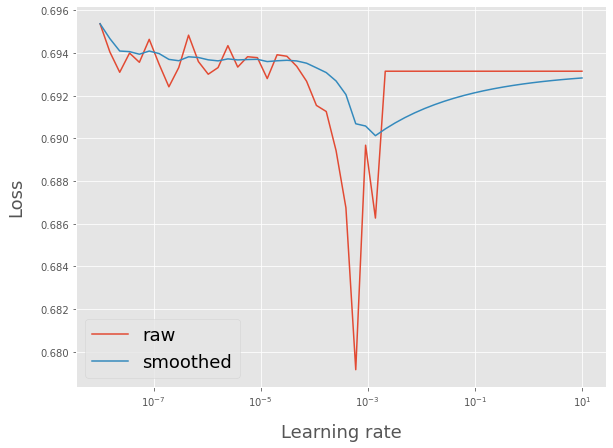

In [64]:
fontsize = 18
plt.close('all')
fix, ax = plt.subplots(1, figsize=(9.5, 7))
lrs = [np.power(10, log_lr) for log_lr in log_lrs]

ax.plot(lrs, raw_losses, label='raw')
ax.plot(lrs, smoothed_losses, label='smoothed')
ax.set_xlabel('Learning rate', fontsize=fontsize, labelpad=15)
ax.set_ylabel('Loss', fontsize=fontsize, labelpad=15)
ax.set_xscale('log')
# ax.set_ylim(0.68, 0.75)
ax.legend(fontsize=fontsize, loc='best')

In [65]:
suggest_lr = np.power(10, log_lrs[np.argmin(smoothed_losses)]) / 10.
print(f'suggested lr: {suggest_lr}')

suggested lr: 0.0001389495494373136


In [102]:
def plot_training_results(epochs, train_epoch_loss,valid_epoch_loss, train_epoch_accuracy, valid_epoch_accuracy, title=''):
    fontsize = 20
    xs = list(range(1, epochs+1))

    plt.close('all')
    fig = plt.figure(figsize=(16, 7))
    gs = matplotlib.gridspec.GridSpec(1, 2)

    ax = plt.subplot(gs[0, 0])
    ax.plot(xs, train_epoch_loss, label='train')
    ax.plot(xs, valid_epoch_loss, label='valid')
    ax.set_xlabel('epoch', fontsize=fontsize, labelpad=15)
    ax.set_ylabel('Loss (binary cross entropy)', fontsize=fontsize, labelpad=15)
    ax.legend(loc='best', fontsize=fontsize)
    adjustAxes(ax, fontsize)

    ax = plt.subplot(gs[0, 1])
    ax.plot(xs, train_epoch_accuracy, label='train')
    ax.plot(xs, valid_epoch_accuracy, label='valid')
    ax.set_xlabel('epoch', fontsize=fontsize, labelpad=15)
    ax.set_ylabel('Accuracy', fontsize=fontsize, labelpad=15)
    ax.legend(loc='best', fontsize=fontsize)
    adjustAxes(ax, fontsize)

    plt.tight_layout(pad=0, w_pad=4.0, h_pad=0)
    if title:
        fig.suptitle(title, fontsize=1.05*fontsize)
    plt.subplots_adjust(top=0.91)    

In [124]:
model = NN(layers)
model = model.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=suggest_lr)
model_save_path = 'model.pkl'
epochs = 100

In [125]:
train_epoch_loss, valid_epoch_loss, train_epoch_accuracy, valid_epoch_accuracy = fit_one_cycle(model, optimizer, loss_func, device, train_dataloader, valid_dataloader, model_save_path, epochs, lr_decay=1.0)


save model params to: model.pkl
epoch 0 completed, training time: 1.3, validation time: 1.14
training loss: 0.64322, validation loss: 0.61436
training accuracy: 0.64997, validation accuracy: 0.74335
 
epoch 20 completed, training time: 1.29, validation time: 1.07
training loss: 0.44710, validation loss: 0.51075
training accuracy: 0.89485, validation accuracy: 0.81035
 
epoch 40 completed, training time: 1.32, validation time: 1.09
training loss: 0.40459, validation loss: 0.51591
training accuracy: 0.93444, validation accuracy: 0.83228
 
epoch 60 completed, training time: 1.28, validation time: 1.04
training loss: 0.38210, validation loss: 0.54971
training accuracy: 0.95727, validation accuracy: 0.83180
 
epoch 80 completed, training time: 1.29, validation time: 1.11
training loss: 0.37134, validation loss: 0.57674
training accuracy: 0.96763, validation accuracy: 0.83528
 


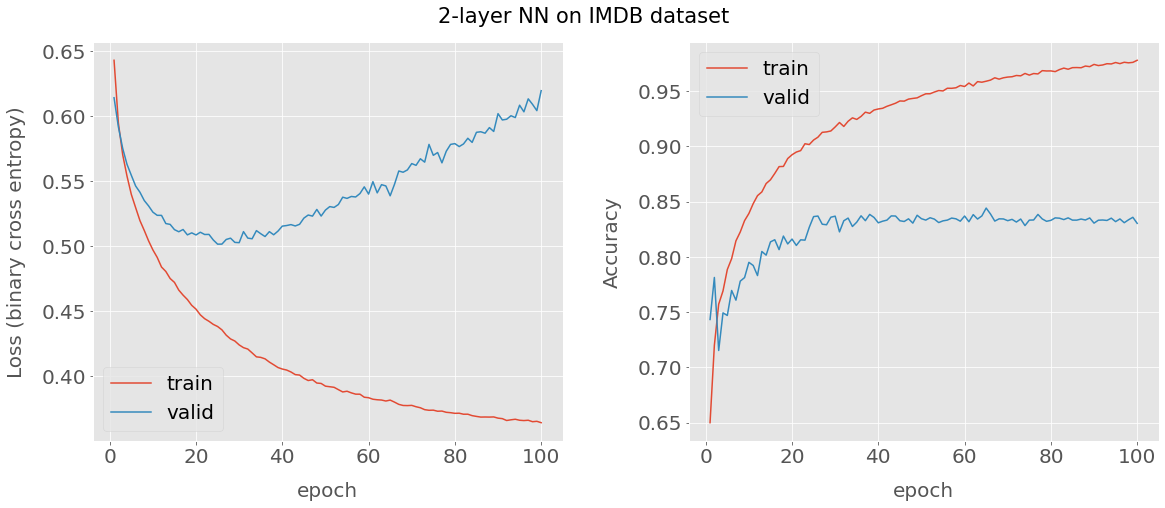

In [126]:
plot_training_results(epochs, train_epoch_loss,valid_epoch_loss, train_epoch_accuracy, valid_epoch_accuracy, '2-layer NN on IMDB dataset')
